In [1]:
import os

import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')

##  developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

## user interface

11:10:35 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1/draws2data
11:11:02 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1/draws2data
11:11:03 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
11:11:03 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/Inven_S1N20Q2R1/draws2data.stan', line 55, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will

chain 1 |          | 00:00 Status

11:11:03 - cmdstanpy - INFO - CmdStan done processing.


KeyError: 'M_c'

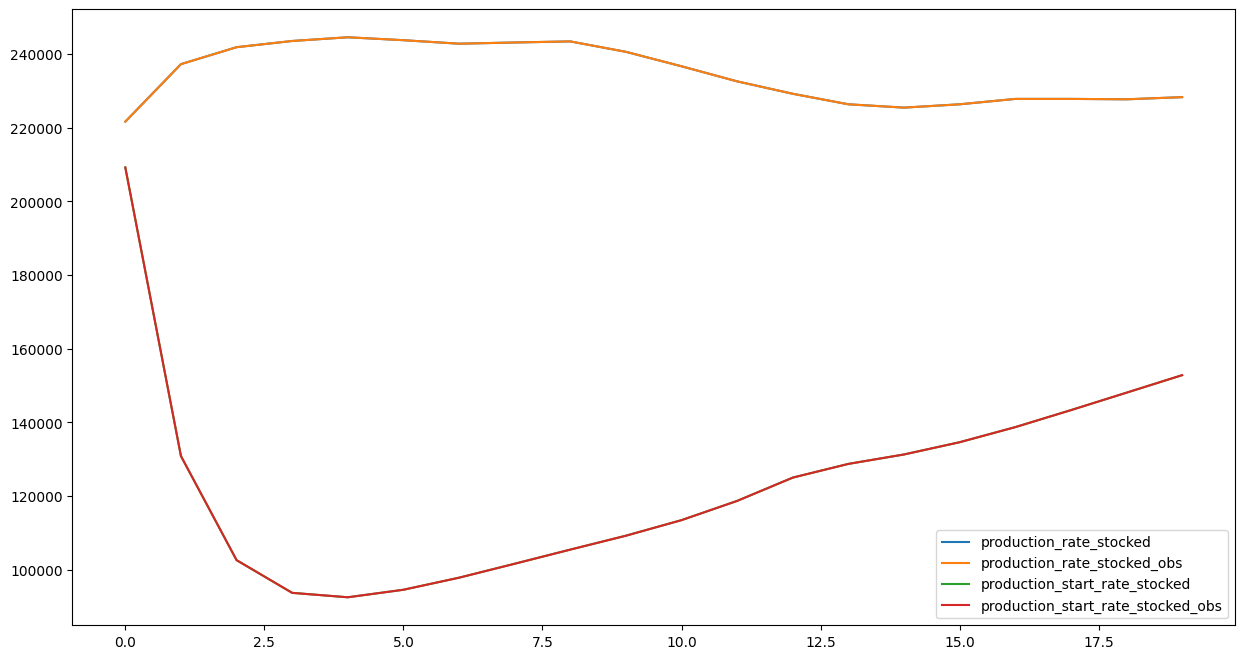

In [2]:
precision ={
    "S": 1, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 20, # # of observation
    "R": 1, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names" : ["inventory_adjustment_time"], #, "wip_adjustment_time"
    "hier_est_param_names": [], #"wip_adjustment_time",
    "target_simulated_vector_names" : ["production_rate_stocked", "production_start_rate_stocked"],
    "driving_vector_names" : ["customer_order_rate", "process_noise_uniform_driving"],
    "model_name": "Inven"
}

numeric = {
    "customer_order_rate": np.tile(pd.read_csv('../input_data/example_retail_sales.csv').iloc[:precision['N'], 1], 1),
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size=precision['N']),
    'process_noise_scale': .1
}

prior = {
    ("inventory_adjustment_time", "normal", 7.00, 0.7, 0),
   # ("wip_adjustment_time", "normal", 2, 0.02, 0),
    ("m_noise_scale", "normal", 0.01, 0.0005, 0)
}

output_format = dict(
    prior_predictive=["production_rate_stocked_obs", "production_start_rate_stocked_obs"],
    posterior_predictive=["production_rate_stocked_obs_post", "production_start_rate_stocked_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'production_rate_stocked': ["time"],
        'production_start_rate_stocked': ["time"],
        'process_noise': ["time"],
        "production_rate_stocked_obs": ["time"],
        "production_start_rate_stocked_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/inventory/inventory.mdl', setting, precision, numeric, prior, output_format)

modelname = "inven_S1N200R1" #TODO model has attribute name so replace this with model.name

We load produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`, `observed_data`. First click the arrow below to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `osberved_data` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

In [ ]:
sbc = az.from_netcdf(f"data/{modelname}/sbc_mpdot01.nc")
sbc.add_groups({"observed_data": sbc.prior_predictive})
sbc

`sbc_inferencedata` type consists of five groups. `prior`, `prior_predictive`, `samp_stats_prior`. Click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `prior` group, observed vector for `prior_predictive` group, lp and acceptance rate for `sample_stats_prior` group).
Posterior group is the estimated result and arviz summary summarizes both estimated result and the quality of the estiamtion.

In [ ]:
sbc.posterior[list(setting['est_param_names'])]

Estimated values are different from groud truth, which is

In [ ]:
for param in setting['est_param_names']:
    print(f'prior value of {param}', sbc.prior[param].values)
    print(f'posterior values of {param}', sbc.posterior[param].values)

summary function returns mean, sd, credible interval for estimated parameter and target simulated vector. mcse, effective sample size (ess), r_hat tells quality of each variables' sample. Refer to [Stan manual](https://mc-stan.org/docs/reference-manual/effective-sample-size.html) for ess details.

In [ ]:
az.summary(sbc.posterior[setting['est_param_names']])

The PPC (prior/poseterior predictive check) plot is a standard way for Bayesian checking. It serves complementary role with simulation-based calibration (SBC). Two checks happen in different space: PPC in observation space as time series, SBC in parameter space as rank comparison between the ground truth and retrieved estimated samples.

In [ ]:
az.plot_ppc(sbc, data_pairs = {'supplyline_obs':'predator_obs_post', 'prey_obs':'prey_obs_post'})

## Diagnose visually with time series, trace, pair, rank plots

### time series of target simulated and its measurement noise added observed vector

### pair plot focused and all

In [ ]:
ax = az.plot_pair(sbc,  var_names=['prey_birth_frac', 'pred_birth_frac'], divergences=True, textsize=22,)

In [ ]:
ax = az.plot_pair(sbc,  divergences=True, textsize=22,) #, backend="bokeh" for interactive plot

## comparing observed data (from prior predictive) with posterior predictive

### rank plot
Rank plots are histograms of the ranked posterior draws (ranked over all chains) plotted separately for each chain. If all of the chains are targeting the same posterior, we expect the ranks in each chain to be uniform, whereas if one chain has a different location or scale parameter, this will be reflected in the deviation from uniformity. If rank plots of all chains look similar, this indicates good mixing of the chains. Plot below indicates bad mixing.



In [ ]:
fig, axes = plt.subplots(1, 2)
az.plot_rank(sbc, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes)


# Appendix

## model

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())